# Disparity Map (Depth Map) from Stereo Vision Images
## (Time Efficient Version)

### Dataset
Dataset from Kitti Stereo 2015: https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo

The datasets used here are already rectified.

#### Reference:
- https://www.baeldung.com/cs/disparity-map-stereo-vision
- https://johnwlambert.github.io/stereo/#first-algorithm

#### Disparity Map
- Stereo vision has 2 visions (e.g. one from left and another from right).
- Image captured from the left camera and the image captured from the right camera have disparity (difference in the position).
- Further the object is from the camera, smaller the disparity. Closer the object is from the camera, greater the disparity.
- Disparity map makes the pixels brighter if there is more disparity. --> In other words, brighter pixels for closer objects. --> Disparity map captures the objects' relative positions.

#### Algorithm Steps
- Image Rectiication: Usually, you first simplify the problem by rectifying the stereo images. After rectification, the corresponding points will lie on the same horizontal line. --> Reduces the 2D stere0 correspondence problem to a 1D problem --> There will be disparity along only one axis (x-axis in this case).
  - 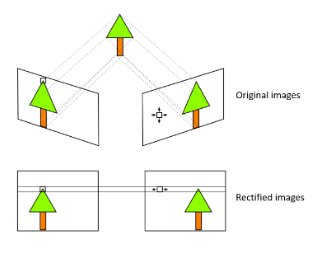
- Block (Window; Kernel) Matching
  - 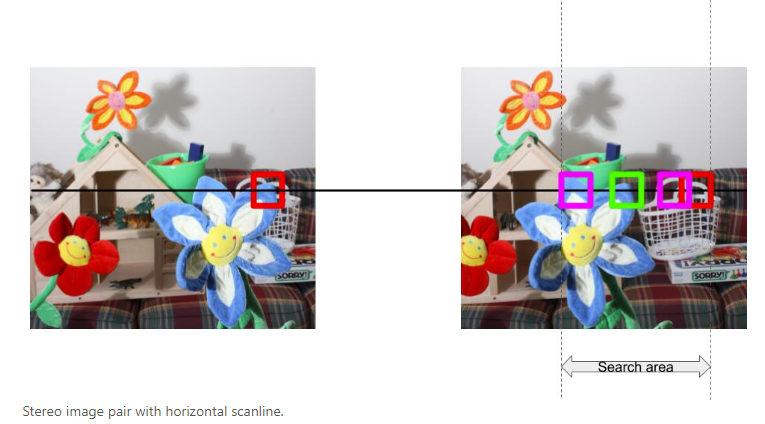
  - 
  - 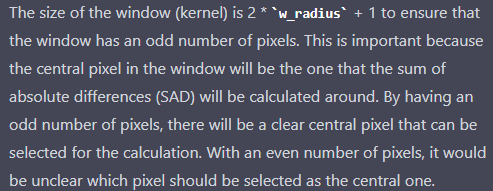
- SAD (Sum of Absolute Differences): The SAD is the sum of the absolute differences between the corresponding pixels in the two images.
  - 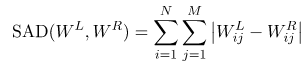
  - 
   

### Set up

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import time

from tqdm import tqdm
from PIL import Image

from scipy.ndimage import shift
from scipy.signal import convolve2d

In [2]:
# image locations
left_img_loc = 'D:/Personal DL Projects/Disparity_Map_with_Stereo_Vision/rectified_images/Kitti_Stereo_2015/data_scene_flow/testing/image_2/'
right_img_loc = 'D:/Personal DL Projects/Disparity_Map_with_Stereo_Vision/rectified_images/Kitti_Stereo_2015/data_scene_flow/testing/image_3/'

# image count
img_count = len(os.listdir(left_img_loc))

### Display Images from Dataset

100%|██████████| 50/50 [00:00<00:00, 92.30it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_3868\4232959773.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_images = np.array(left_images)
100%|██████████| 50/50 [00:00<00:00, 87.91it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_3868\4232959773.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  right_images = np.array(right_images)


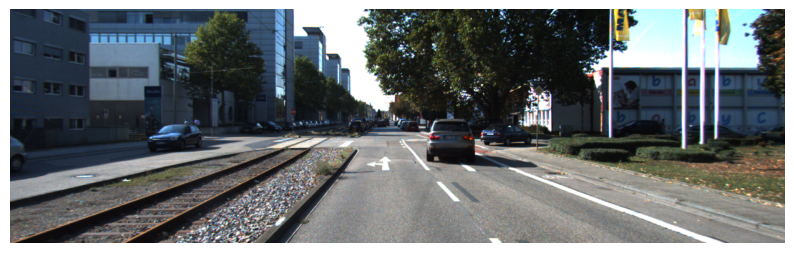

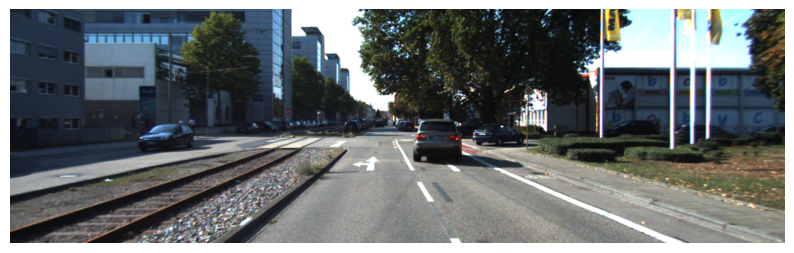

In [3]:
left_images = []
for img_file in tqdm(os.listdir(left_img_loc)[:img_count]):
    pic = Image.open(left_img_loc + img_file)
    left_images.append(np.uint8(pic))
left_images = np.array(left_images)

right_images = []
for img_file in tqdm(os.listdir(right_img_loc)[:img_count]):
    pic = Image.open(right_img_loc + img_file)
    right_images.append(np.uint8(pic))
right_images = np.array(right_images)

# Display first left and right images
plt.figure(1, figsize=(10,10))
plt.imshow(left_images[0])
plt.axis('off') # make the increment marks on the axes invisible
plt.show()
plt.figure(1, figsize=(10,10))
plt.imshow(right_images[0])
plt.axis('off') # make the increment marks on the axes invisible
plt.show()


### Convert RGB Images to Grayscale

100%|██████████| 50/50 [00:00<00:00, 100.48it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_3868\2599495367.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  left_images_gray = np.array(left_images_gray)
100%|██████████| 50/50 [00:00<00:00, 100.26it/s]
C:\Users\whdqk\AppData\Local\Temp\ipykernel_3868\2599495367.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  right_images_gray = np.array(right_images_gray)


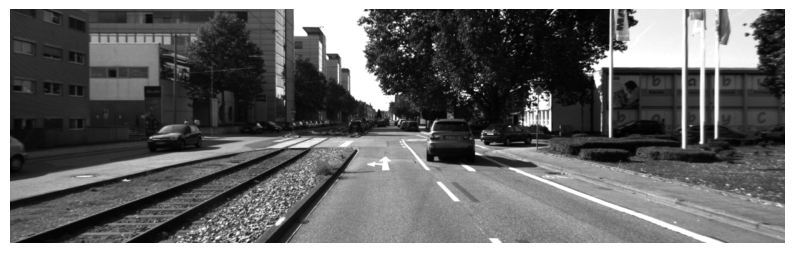

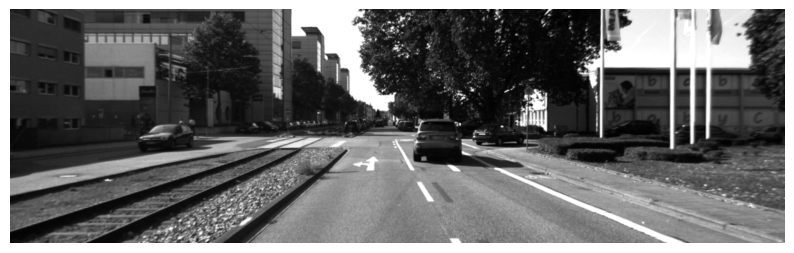

In [4]:
left_images_gray = []
for img_file in tqdm(left_images):
    pic_gray = np.mean(img_file, axis=2).astype(np.uint8)
    left_images_gray.append(pic_gray)
left_images_gray = np.array(left_images_gray)

right_images_gray = []
for img_file in tqdm(right_images):
    pic_gray = np.mean(img_file, axis=2).astype(np.uint8)
    right_images_gray.append(pic_gray)
right_images_gray = np.array(right_images_gray)

total_images_gray = np.hstack((left_images_gray, right_images_gray))

# Display first left and right images
plt.figure(1, figsize=(10,10))
plt.imshow(left_images_gray[0], cmap='gray')
plt.axis('off') # make the increment marks on the axes invisible
plt.show()
plt.figure(1, figsize=(10,10))
plt.imshow(right_images_gray[0], cmap='gray')
plt.axis('off') # make the increment marks on the axes invisible
plt.show()

### Generate Disparity Maps (Depth Maps) - Time Efficient Algorithm

In [5]:
# hyperparameters
min_d = 0 # minimum disparity to slide the window in the right image per center pixel of the window in the left image
max_d = 64 # maximum disparity to slide the window in the right image per center pixel of the window in the left image
w_radius = 4 # window radius (window size = 2*w_radius + 1)

In [6]:
disparity_map_lists = [] # list to store disparity maps

## Through out the images
for left_img, right_img in zip(left_images_gray, right_images_gray):

    ## Convert images to double
    # The reason for converting the images to double is to ensure that the calculations performed on the images have high precision.
    left_img = np.double(left_img) # convert to double
    right_img = np.double(right_img) # convert to double

    ## Initialize variables
    height, width = left_img.shape # height (row) and width (col) of the image
    kernel_size = 2*w_radius + 1 # kernel size (window size)
    search_area = np.arange(min_d, max_d+1) # search area (disparity range) for disparity in the right image

    ## Preallocation
    disparity_map = np.zeros((height, width)) # preallocatin of disparity map
    AD = np.zeros((height, width, len(search_area))) # preallocation of AD (Absolute Difference)
    kernel = np.ones((kernel_size, kernel_size)) # preallocation of kernel (window)
    
    ## Loop over each disparity value
    for i in tqdm(range(len(search_area))):
        d = search_area[i] # disparity value

        # Shift the right image to the right (= shift the pixel to the left)
        right_img_shifted = shift(right_img, (0, d)) # shift the right image to the right (= shift the pixel to the left)
        
        # Calculate the absolute difference between the left image and the shifted right image
        AD[:,:,i] = np.abs(left_img - right_img_shifted) # absolute difference
    
    # Calculate the SAD (Sum of Absolute Differences) for each pixel
    SAD = np.zeros_like(AD)
    for i in range(len(search_area)):
        SAD[:,:,i] = convolve2d(AD[:,:,i], kernel, mode='same')

    # Convert the indices to diaprity values
    min_indices = np.argmin(SAD, axis=2)

    # Disparity map
    disparity_map = search_area[min_indices] # convert the indices to diaprity values

    disparity_map_lists.append(disparity_map) # append the disparity map to the list


100%|██████████| 65/65 [00:03<00:00, 16.33it/s]


### Create GIFs of the Images & Corresponding Disparity Maps (Depth Maps)

In [7]:
import imageio
import glob

# left images
image_list = []
for img in left_images:
    image_list.append(img)
imageio.mimsave('left_images.gif', image_list, duration=0.3)

# disparity maps (depth maps)
depth_map_image_list = []
for map in disparity_map_lists:
    depth_map_image_list.append(map)
imageio.mimsave('depth_maps.gif', depth_map_image_list, duration=0.3)

Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 64]. Con

### Display Disparity Maps
Brighter pixel the closer the it is from the stereo camera.
- the disparity (position difference) of the objects in the left image and the right image is smaller.
- has a smaller SAD (Sum of Absolute Differences).
- the disparity value becomes the pixel value of the disparity map.
- Summary:
  - Object is closer to the stereo camera --> smaller SAD --> smaller disparity (difference) between the pixels in the left and right images --> smaller disparity becomes the value of the corresponding pixel in the disparity map --> smaller value means the color is lighter --> lighter pixel means it is closer to the stereo camera

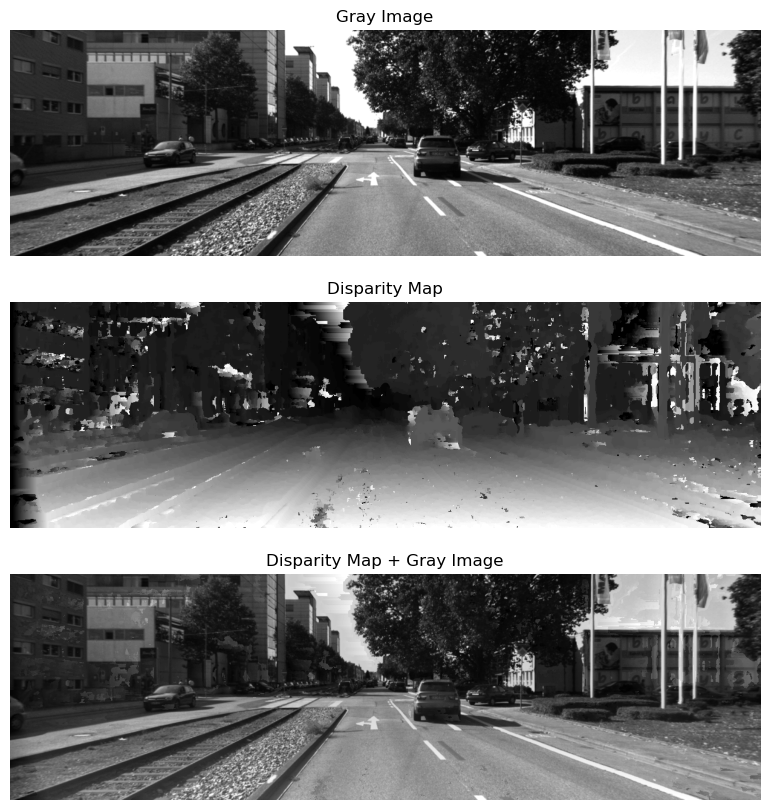

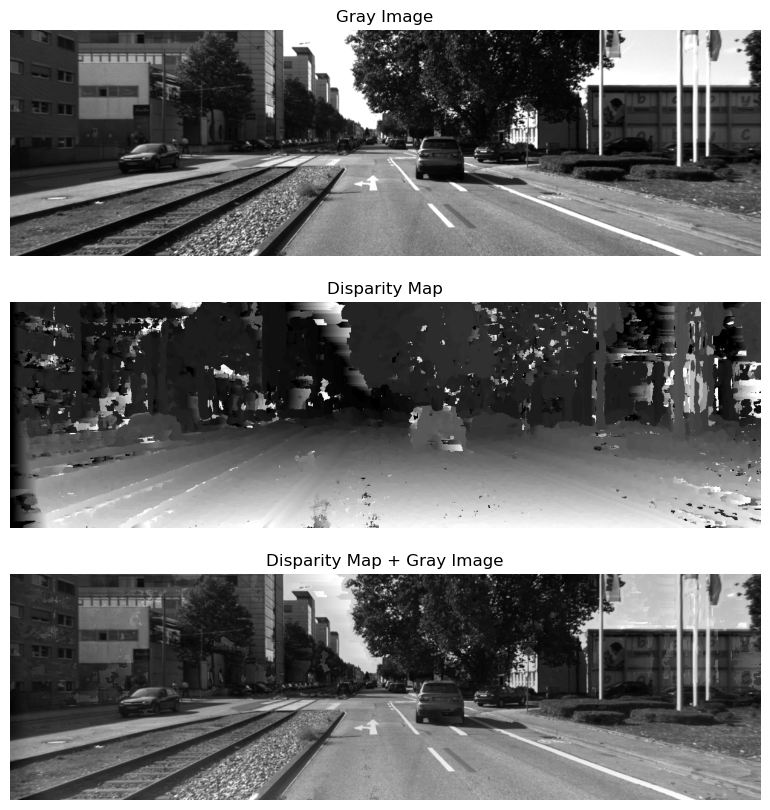

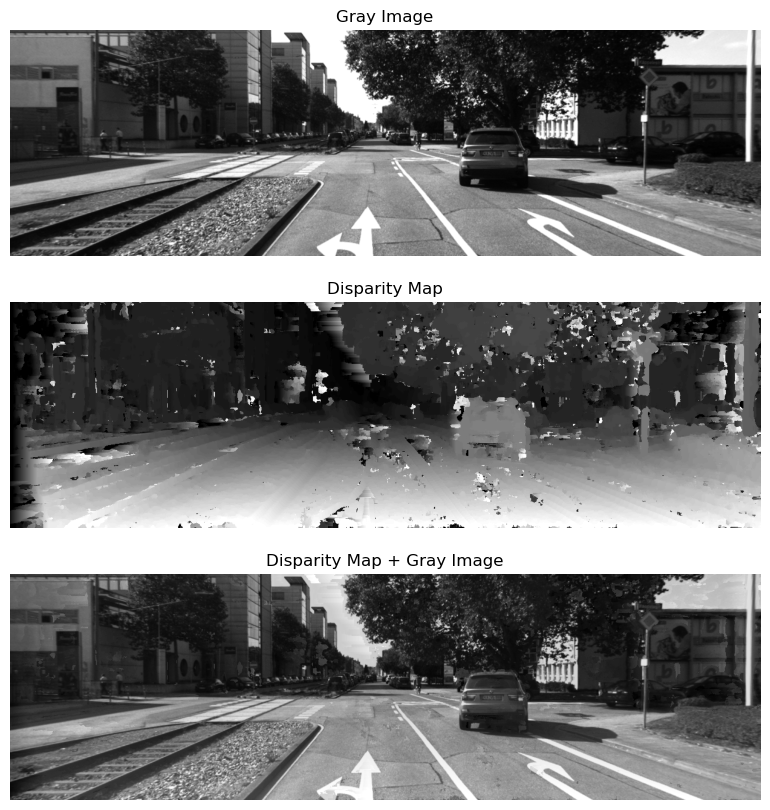

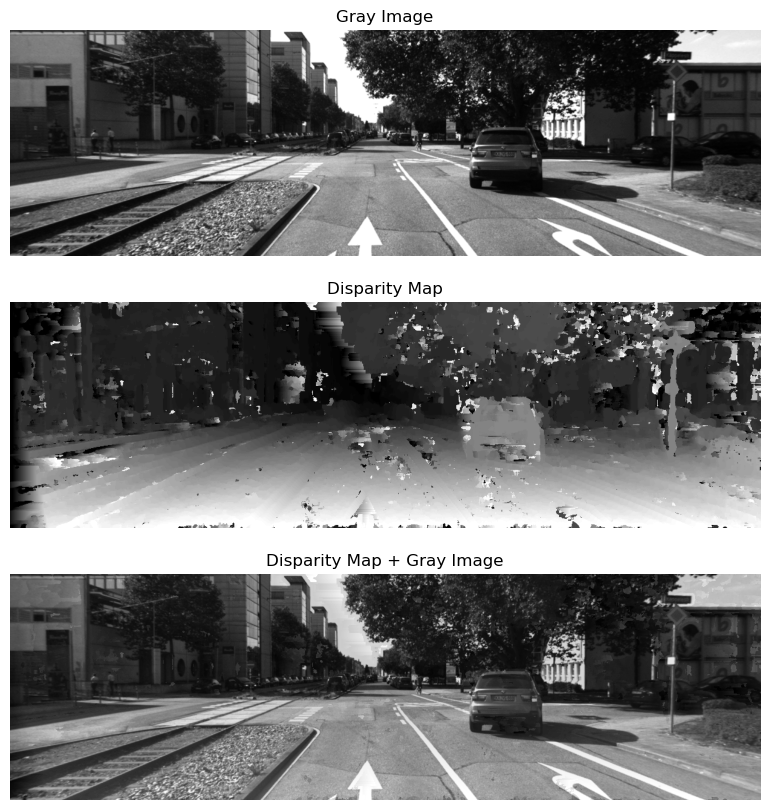

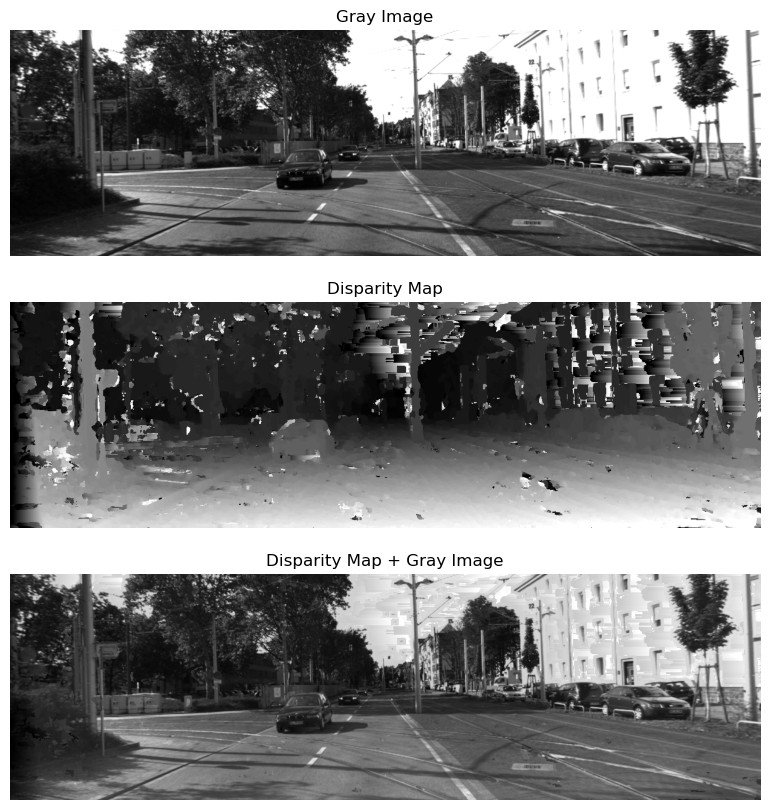

In [8]:
## Display a portion of disparity maps generated
for i in range(len(disparity_map_lists)//10):
    # plot
    plt.figure(i+1, figsize=(10,10))

    plt.subplot(3,1, 1)
    plt.title("Gray Image")
    plt.imshow(left_images_gray[i], cmap = plt.cm.gray)
    plt.axis('off') # make the increment marks on the axes invisible

    plt.subplot(3,1, 2)
    plt.title("Disparity Map")
    plt.imshow(disparity_map_lists[i], vmin=0, vmax=max_d, cmap='gray') # vmin and vmax are used to set the color limits. Outliers will be clipped.
    plt.axis('off') # make the increment marks on the axes invisible

    plt.subplot(3,1, 3)
    plt.title("Disparity Map + Gray Image")
    plt.imshow(disparity_map_lists[i] + left_images_gray[i], cmap='gray')
    plt.axis('off') # make the increment marks on the axes invisible

    plt.show()
